# MELI 2020

Evaluación


Métrica
Las cargas serán evaluadas utilizando el promedio de NDCG (Normalized Discounted Cumulative Gain o Ganancia Acumulada Descontada y Normalizada).

NDCG es un método popular para medir la calidad de los resultados de un set. La métrica puede ser fácilmente adaptada al dominio de las recomendaciones.

NDCG se basa en las siguientes premisas:


* Ganancia Acumulada: Recomendaciones muy relevantes son más útiles que las recomendaciones algo relevantes, que son a su vez más útiles que recomendaciones irrelevantes (es decir, queremos recomendar publicaciones relevantes al usuario).
* Descuento: Las recomendaciones relevantes son más útiles cuando aparecen antes en el set de recomendaciones (es decir, el orden importa).
* Normalización: La métrica debe estar en el intervalo [0,1].


En otras palabras, NDCG es solo la Ganancia Acumulada Descontada dividida por la Ganancia Acumulada Descontada del conjunto de recomendaciones ideal.

Ahora, ¿cómo calculamos la Ganancia Acumulada Descontada?

Bueno, podríamos sumar la relevancia de cada elemento en el conjunto de recomendaciones (esto nos dará la Ganancia Acumulada). El problema con esta métrica es que no tiene en cuenta la forma en que se ordenan los elementos recomendados. Así, recomendar el artículo adecuado en la 10° posición será tan valorado como hacerlo en la 1° posición.

No queremos que esto suceda, es por eso que descontamos la Ganancia Acumulada ponderando cada relevancia inversamente a su posición, usando logaritmos para enfatizar este efecto.


Esto significa que...


* Si acertaras el item_id de la compra objetivo del usuario, obtendrás una relevancia de 12 para esa recomendación en su conjunto de recomendaciones.

* En cambio, si la predicción no coincide con el ID de artículo correcto, pero corresponde al mismo dominio, obtendrá 1 punto de relevancia.

* En caso de que no coincida con ninguno de ellos, su relevancia será 0.

El conjunto de recomendaciones ideal será aquel compuesto por el mismo ID de artículo que el objetivo en la primera posición, seguido de 9 IDs de artículos que pertenezcan al mismo ID de dominio que el artículo objetivo en las recomendaciones restantes.


# DATA

In [1]:
import os
import warnings
import json
warnings.filterwarnings('ignore')
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_columns=100

In [3]:
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing

In [4]:
import texthero as hero

In [5]:
%matplotlib inline

In [6]:
meli_train = pd.read_json('data/train_dataset.jl', lines=True)
meli_item  = pd.read_json('data/item_data.jl',lines=True)

In [7]:
meli_item["item_id"].nunique()

2102277

# SHAPE

In [8]:
meli_train.shape

(413163, 2)

In [9]:
meli_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413163 entries, 0 to 413162
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_history  413163 non-null  object
 1   item_bought   413163 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.3+ MB


In [10]:
meli_train.head()

,user_history,item_bought
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830
1,"[{'event_info': 643652, 'event_timestamp': '20...",228737
2,"[{'event_info': 248595, 'event_timestamp': '20...",1909110
3,"[{'event_info': 'RADIOBOSS', 'event_timestamp'...",1197370
4,"[{'event_info': 'AMAZFIT BIP', 'event_timestam...",2049207


In [11]:
meli_train["item_bought"].nunique()

64928

In [12]:
meli_train["item_bought"].value_counts()

1587422    558
1803710    384
10243      371
548905     348
1906937    344
          ... 
1509539      1
1585314      1
2076852      1
1044668      1
445529       1
Name: item_bought, Length: 64928, dtype: int64

In [13]:
meli_train["user_history"][0]

[{'event_info': 1786148,
  'event_timestamp': '2019-10-19T11:25:42.444-0400',
  'event_type': 'view'},
 {'event_info': 1786148,
  'event_timestamp': '2019-10-19T11:25:57.487-0400',
  'event_type': 'view'},
 {'event_info': 'RELOGIO SMARTWATCH',
  'event_timestamp': '2019-10-19T11:26:07.063-0400',
  'event_type': 'search'},
 {'event_info': 1615991,
  'event_timestamp': '2019-10-19T11:27:26.879-0400',
  'event_type': 'view'},
 {'event_info': 1615991,
  'event_timestamp': '2019-10-19T11:28:36.558-0400',
  'event_type': 'view'},
 {'event_info': 1615991,
  'event_timestamp': '2019-10-19T11:28:40.827-0400',
  'event_type': 'view'},
 {'event_info': 1615991,
  'event_timestamp': '2019-10-19T11:30:42.089-0400',
  'event_type': 'view'},
 {'event_info': 1615991,
  'event_timestamp': '2019-10-19T21:51:29.622-0400',
  'event_type': 'view'},
 {'event_info': 1615991,
  'event_timestamp': '2019-10-19T21:52:09.281-0400',
  'event_type': 'view'},
 {'event_info': 1615991,
  'event_timestamp': '2019-10-19T

In [14]:
meli_item.shape

(2102277, 7)

In [15]:
meli_item.head()

,item_id,title,domain_id,product_id,price,category_id,condition
0,111260,Casa Sola En Venta Con Gran Patio Solo Pago De...,MLM-INDIVIDUAL_HOUSES_FOR_SALE,NaN,1150000.00,MLM170527,new
1,871377,Resident Evil Origins Collection Nintendo Swit...,MLM-VIDEO_GAMES,15270800.0,1392.83,MLM151595,new
2,490232,Falda De Imitación Piel Negra,MLM-SKIRTS,NaN,350.00,MLM7697,new
3,1150706,Powercolor Red Devil Radeon Rx 580 8gb Gddr5,MLM-GRAPHICS_CARDS,NaN,3200.00,MLM9761,used
4,934912,Laptop Hp Nx6320 Core Duo Con Puerto Db9 Windo...,MLM-NOTEBOOKS,NaN,1599.00,MLM1652,used


## JOIN

In [16]:
train = pd.merge(meli_train,meli_item,how="left",left_on=["item_bought"],right_on=["item_id"])

In [17]:
train.head()

,user_history,item_bought,item_id,title,domain_id,product_id,price,category_id,condition
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830,1748830,Relógio Medidor Inteligente Pulso Freqüência C...,MLB-SMARTWATCHES,NaN,90.00,MLB135384,new
1,"[{'event_info': 643652, 'event_timestamp': '20...",228737,228737,Bomba Eletrica Tira Leite Materno Bivolt G-tech,MLB-MILK_EXTRACTORS,9015547.0,169.00,MLB264021,new
2,"[{'event_info': 248595, 'event_timestamp': '20...",1909110,1909110,"Kit Youtuber Tripé 1,20 Microfone Lapela Anel ...",MLB-CELLPHONE_ACCESSORIES,NaN,300.00,MLB5092,new
3,"[{'event_info': 'RADIOBOSS', 'event_timestamp'...",1197370,1197370,Leia A Descrição Por Favor - Maquininha Point ...,MLB-CARD_PAYMENT_TERMINALS,NaN,16.90,MLB277951,new
4,"[{'event_info': 'AMAZFIT BIP', 'event_timestam...",2049207,2049207,Smartwatch Xiaomi Amazfit Bip Huami A1608 Orig...,MLB-SMARTWATCHES,9070839.0,355.99,MLB135384,new


In [18]:
train["title"].value_counts()

Xiaomi Redmi Note 7 (48 Mpx) Dual Sim 64 Gb Space Black 4 Gb Ram    938
Fone De Ouvido Bluetooth Xiaomi Redmi Airdots                       609
Xiaomi Redmi Note 7 Dual Sim 64 Gb Neptune Blue 4 Gb Ram            608
Celular Samsung Galaxy A30 Dual 64gb 4gb Ram A305 Azul              559
Relogio Bluetooth Wifi Smartwatch A1 Camera Celular Chip            490
                                                                   ... 
Bebedouro De Mesa Esmaltec Egm30 110v                                 1
Multímetro Capacitómetro, Faradios, Voltaje, Amperaje, Ohms           1
Limpieza Repo Imei Recupera Señal  Movistar Telcel Para Att           1
Super Combo 4x Bcaa Em Pó 3500mg - 300g - Midway                      1
Capa Magnética 360° Xiaomi Mi 9 Se Global + Pelicula Mi9se            1
Name: title, Length: 59710, dtype: int64

In [19]:
train["domain_id"].value_counts()

MLB-CELLPHONES                       25070
MLB-SNEAKERS                         14608
MLB-SUPPLEMENTS                       9562
MLB-HEADPHONES                        9053
MLB-SMARTWATCHES                      7963
                                     ...  
MLB-TOY_SOLDIERS                         1
MLB-DIRECT_BOXES                         1
MLB-SPICES                               1
MLB-NAUTICAL_WATER_PUMP_IMPELLERS        1
MLB-KITCHEN_BOWLS                        1
Name: domain_id, Length: 3214, dtype: int64

In [20]:
train["category_id"].value_counts()

MLB1055      25070
MLB23332     14427
MLB122102     7905
MLB135384     7810
MLB7457       6423
             ...  
MLB236048        1
MLM439636        1
MLB431487        1
MLM194185        1
MLM189448        1
Name: category_id, Length: 4001, dtype: int64

In [21]:
train["condition"].value_counts()

new              412637
used                411
not_specified       115
Name: condition, dtype: int64

In [22]:
train[train["condition"]=="used"]["domain_id"].value_counts()

MLM-UNCLASSIFIED_PRODUCTS                            60
MLB-GAME_CONSOLES                                    49
MLB-CELLPHONES                                       33
MLB-UNCLASSIFIED_PRODUCTS                            27
MLB-GAMEPADS_AND_JOYSTICKS                           25
MLM-VIDEO_GAMES                                      24
MLB-VIDEO_GAMES                                      23
MLB-HARD_DRIVES_AND_SSDS                             17
MLB-WEBCAMS                                          15
MLB-COMPUTER_EQUIPMENT_AND_SPARE_PARTS               14
MLM-POGS                                             12
MLB-SUPPLEMENTS                                      12
MLB-COLLECTIBLE_POSTCARDS                            10
MLB-WRISTWATCHES                                      8
MLB-FOODS_AND_DRINKS                                  8
MLB-LADDERS                                           7
MLM-VIDEO_GAME_PREPAID_CARDS                          6
MLM-GAME_CONSOLES_VIDEO_GAMES_AND_ARCADE_MACHINE

In [23]:
train["user_history"][10]

[{'event_info': 'HARMAN KARDON',
  'event_timestamp': '2019-10-26T11:59:00.194-0400',
  'event_type': 'search'},
 {'event_info': 658101,
  'event_timestamp': '2019-10-26T11:59:12.509-0400',
  'event_type': 'view'},
 {'event_info': 'HARMAN KARDON',
  'event_timestamp': '2019-10-26T11:59:25.731-0400',
  'event_type': 'search'},
 {'event_info': 'HARMAN KARDON',
  'event_timestamp': '2019-10-26T11:59:38.963-0400',
  'event_type': 'search'},
 {'event_info': 'HARMAN KARDON',
  'event_timestamp': '2019-10-26T11:59:50.750-0400',
  'event_type': 'search'},
 {'event_info': 'MEMORIA DDR4',
  'event_timestamp': '2019-10-26T19:55:23.776-0400',
  'event_type': 'search'},
 {'event_info': 'MEMORIA DDR4 NOTEBOOK',
  'event_timestamp': '2019-10-26T19:55:38.581-0400',
  'event_type': 'search'},
 {'event_info': 'MEMORIA DDR4 NOTEBOOK',
  'event_timestamp': '2019-10-26T19:56:15.826-0400',
  'event_type': 'search'},
 {'event_info': 'MEMORIA DDR4 NOTEBOOK',
  'event_timestamp': '2019-10-26T19:57:18.413-0400'

In [24]:
pd.DataFrame(train["user_history"][10])

,event_info,event_timestamp,event_type
0,HARMAN KARDON,2019-10-26T11:59:00.194-0400,search
1,658101,2019-10-26T11:59:12.509-0400,view
2,HARMAN KARDON,2019-10-26T11:59:25.731-0400,search
3,HARMAN KARDON,2019-10-26T11:59:38.963-0400,search
4,HARMAN KARDON,2019-10-26T11:59:50.750-0400,search
5,MEMORIA DDR4,2019-10-26T19:55:23.776-0400,search
6,MEMORIA DDR4 NOTEBOOK,2019-10-26T19:55:38.581-0400,search
7,MEMORIA DDR4 NOTEBOOK,2019-10-26T19:56:15.826-0400,search
8,MEMORIA DDR4 NOTEBOOK,2019-10-26T19:57:18.413-0400,search


In [25]:
meli_item[meli_item["title"].str.contains("Harman Kardon")]

,item_id,title,domain_id,product_id,price,category_id,condition
4149,662449,Harman Kardon Invoke / Microsoft Cortana Bluet...,MLM-SPEAKERS,NaN,2400.00,MLM2868,new
11470,2053675,Teatro En Casa Harman Kardon Hts15 Con Amplifi...,MLM-HOME_THEATERS,NaN,26000.00,MLM5845,new
13201,1148212,Harman Kardon Aura Studio2 - Altavoz Inalámbri...,MLM-SPEAKERS,8981710.0,6430.87,MLM59800,new
20695,1495967,Bocina Harman Kardon Onyx Studio 5 Bluetooth 8...,MLM-SPEAKERS,15106220.0,4999.00,MLM59800,new
23979,542195,Bocinas Harman Kardon Soundsticks Ii,MLM-SPEAKERS,NaN,3000.00,MLM2868,used
...,...,...,...,...,...,...,...
2029097,1235592,Caixa Som Harman Kardon Onyx Studio 5 50w Preto,MLB-UNCLASSIFIED_PRODUCTS,NaN,795.99,MLB3530,not_specified
2036367,705542,Home Theater Harman Kardon Avr130 Usado,MLB-AV_RECEIVERS,9140360.0,690.00,MLB11509,used
2038552,658101,Caixa De Som Onix 3 60rms Bluetooth - Harman K...,MLB-SPEAKERS,NaN,899.00,MLB3843,new
2056221,767334,Bateria Recarregável Para Caixa De Som Harman ...,MLB-SPEAKERS,NaN,279.00,MLB3843,new


In [26]:
meli_item["title_clean"]=hero.clean(meli_item["title"])

In [27]:
meli_item[["title","title_clean"]].head(50)

,title,title_clean
0,Casa Sola En Venta Con Gran Patio Solo Pago De...,casa venta patio pago contado
1,Resident Evil Origins Collection Nintendo Swit...,resident evil origins collection nintendo swit...
2,Falda De Imitación Piel Negra,falda imitacion piel negra
3,Powercolor Red Devil Radeon Rx 580 8gb Gddr5,powercolor red devil radeon rx 8gb gddr5
4,Laptop Hp Nx6320 Core Duo Con Puerto Db9 Windo...,laptop hp nx6320 core duo puerto db9 windows
5,Transmisor Fm Sin Hilos Bluetooth Reproductor ...,transmisor fm hilos bluetooth reproductor mp3 co
6,Funda Cartera Caseme 007 2 En 1 Huawei P30 Pro,funda cartera caseme huawei p30 pro
7,Lampara De Techo Tubo Slim Led Base G5 9w Blan...,lampara techo tubo slim led base g5 9w blanco ...
8,"Repisa Organizador Para Cocina, Especieros, T...",repisa organizador cocina especieros toallero
9,"Trío, Balerina, Cosmo, Leopardo/negro/rojo, Ve...",trio balerina cosmo leopardo negro rojo verano...


In [28]:
train.drop(columns=["item_id","product_id","condition"],inplace=True)

# START

## LEN

In [29]:
train["len_user_history"]=train["user_history"].apply(lambda x:len(x))

In [30]:
def len_search(row):
    log=[]
    for event in row:
        if event["event_type"]=="search":
            log.append(event["event_info"])
    if len(log)==0: return 0
    else: return len(log)

In [31]:
def len_view(row):
    log=[]
    for event in row:
        if event["event_type"]=="view":
            log.append(event["event_info"])
    if len(log)==0: return 0
    else: return len(log)

In [32]:
train["number_search"]=train["user_history"].apply(len_search)
train["number_view"]=train["user_history"].apply(len_view)

In [33]:
train[["len_user_history","number_search","number_view"]].describe(percentiles=np.arange(0.1,1,0.1))

,len_user_history,number_search,number_view
count,413163.000000,413163.000000,413163.000000
mean,29.042209,14.689478,14.352730
std,36.278935,20.457799,19.293081
min,1.000000,0.000000,0.000000
10%,2.000000,0.000000,1.000000
20%,4.000000,1.000000,2.000000
30%,7.000000,2.000000,3.000000
40%,11.000000,4.000000,5.000000
50%,16.000000,7.000000,7.000000
60%,22.000000,11.000000,11.000000


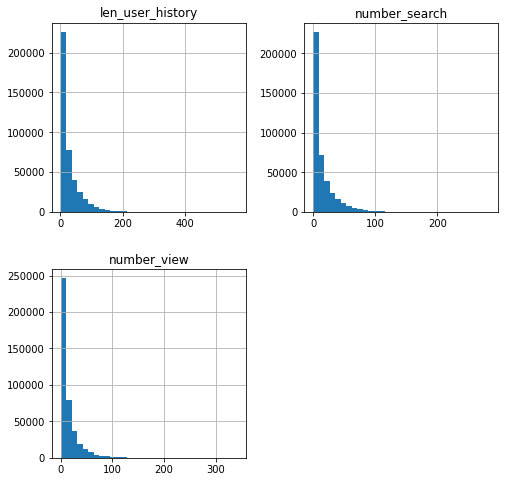

In [34]:
train[["len_user_history","number_search","number_view"]].hist(bins=32,figsize=(8,8));


In [35]:
train[["len_user_history","number_search","number_view"]].corr()

,len_user_history,number_search,number_view
len_user_history,1.000000,0.917868,0.907132
number_search,0.917868,1.000000,0.665600
number_view,0.907132,0.665600,1.000000


In [36]:
train[train["len_user_history"]==1].head()

,user_history,item_bought,title,domain_id,price,category_id,len_user_history,number_search,number_view
34,"[{'event_info': 1916217, 'event_timestamp': '2...",887130,Spiderman Homem Aranha Mídia Física Lacrado,MLB-VIDEO_GAMES,119.90,MLB186456,1,0,1
75,"[{'event_info': 87338, 'event_timestamp': '201...",1777682,Adata Disco Duro Solido Ssd Sata Laptop Pc 120...,MLM-HARD_DRIVES_AND_SSDS,489.00,MLM1672,1,0,1
76,"[{'event_info': 'FIAT UNO VIVACE', 'event_time...",1847644,Relógio Mi Band 4 Xiaomi Versão Global Origina...,MLB-SMARTWATCHES,184.99,MLB135384,1,1,0
91,"[{'event_info': 42654, 'event_timestamp': '201...",671264,Fones De Ouvido Sem Fio Bluetooth I7s Tws,MLB-HEADPHONES,50.00,MLB7457,1,0,1
99,"[{'event_info': 905388, 'event_timestamp': '20...",443165,Kit Fusivel De Lamina 05a 10a 15a 20a 25a 30a ...,MLB-INDUSTRIAL_FUSES,28.90,MLB270084,1,0,1


In [37]:
train[train["len_user_history"]==1].shape

(31631, 9)

In [38]:
train[train["len_user_history"]==1][["number_search","number_view"]].sum()

number_search     9890
number_view      21741
dtype: int64

In [39]:
train[train["number_view"]==0].head(3)

,user_history,item_bought,title,domain_id,price,category_id,len_user_history,number_search,number_view
17,"[{'event_info': 'JBL GO 2', 'event_timestamp':...",232,Caixa Bluetooth Jbl Go2 Original Lacrada Vária...,MLB-SPEAKERS,157.90,MLB3843,2,2,0
28,"[{'event_info': 'COLETE POSTURA FEMININO', 'ev...",1587395,Caixa Som Bluetooth Xtreme Mini Potente 40w Rm...,MLB-SPEAKERS,124.99,MLB3843,3,3,0
63,"[{'event_info': 'CAMISAS MASCULINAS', 'event_t...",1019254,Roteador Tp Link 949n 450mbps 3 Antenas 5dbi F...,MLB-ROUTERS_AND_WIRELESS_SYSTEMS,149.00,MLB5867,27,27,0


In [40]:
train[train["len_user_history"]==train["len_user_history"].max()]

,user_history,item_bought,title,domain_id,price,category_id,len_user_history,number_search,number_view
131539,"[{'event_info': 'DHEA', 'event_timestamp': '20...",1367860,Receita Salada Fit - P/ Dieta! Via E-mail,MLB-FOODS_AND_DRINKS,1.1,MLB1417,566,284,282


In [41]:
train[train["len_user_history"]==train["len_user_history"].max()]["user_history"].iloc[0]

[{'event_info': 'DHEA',
  'event_timestamp': '2019-10-06T15:24:43.848-0400',
  'event_type': 'search'},
 {'event_info': 'DHEA',
  'event_timestamp': '2019-10-06T15:25:17.611-0400',
  'event_type': 'search'},
 {'event_info': 'DHEA',
  'event_timestamp': '2019-10-06T15:25:20.788-0400',
  'event_type': 'search'},
 {'event_info': 'DHEA',
  'event_timestamp': '2019-10-06T15:25:25.083-0400',
  'event_type': 'search'},
 {'event_info': 'DHEA',
  'event_timestamp': '2019-10-06T15:25:33.448-0400',
  'event_type': 'search'},
 {'event_info': 'DHEA',
  'event_timestamp': '2019-10-06T15:25:40.990-0400',
  'event_type': 'search'},
 {'event_info': 1588842,
  'event_timestamp': '2019-10-06T15:26:41.180-0400',
  'event_type': 'view'},
 {'event_info': 1588842,
  'event_timestamp': '2019-10-06T15:27:01.383-0400',
  'event_type': 'view'},
 {'event_info': 'DHEA',
  'event_timestamp': '2019-10-06T15:27:02.410-0400',
  'event_type': 'search'},
 {'event_info': 1193736,
  'event_timestamp': '2019-10-06T15:27:12

## COUNT

In [42]:
count_item_domain = train.groupby(["domain_id","item_bought"])["title"].count().reset_index()
count_item_domain=count_item_domain.rename(columns={"title": "count"})
count_item_domain=count_item_domain.groupby(["domain_id"]).apply(lambda x: x.nlargest(15,['count'])).reset_index(drop=True)

In [43]:
top_sell_domain = {}
for domain in count_item_domain["domain_id"].unique():
    top_sell_domain[domain]=count_item_domain[count_item_domain.domain_id==domain].set_index("item_bought")[["count"]].to_dict()["count"]

1. Get Count Items purchase
2. Get Count Items Views
3. Get Count Items Search

In [44]:
from collections import Counter
from operator import itemgetter
from heapq import nlargest
get_recent = itemgetter("event_timestamp")

In [45]:
def get_count_purchase(row):
    log=[]
    for event in row:
        if "purchases" in event["event_type"].lower():
            log.append(event["event_info"])
    if len(log)==0: return "NONE"
    else: return dict(Counter(log))
    
def get_count_search(row):
    log=[]
    for event in row:
        if event["event_type"]=="search":
            log.append(event["event_info"])
    if len(log)==0: return "NONE"
    else: return dict(Counter(log))

def get_count_view(row):
    log=[]
    for event in row:
        if event["event_type"]=="view":
            log.append(event["event_info"])
    if len(log)==0: return "NONE"
    else: return dict(Counter(log))

In [46]:
train["count_purchase"]=train["user_history"].apply(get_count_purchase)
train["count_view"]=train["user_history"].apply(get_count_view)
train["count_search"]=train["user_history"].apply(get_count_search)

In [47]:
def get_max_view(row):
    if row["number_view"]==0: return np.nan
    log=[]
    for event in row["user_history"]:
        if event["event_type"]=="view":
            log.append(event["event_info"])
    dicc = dict(Counter(log))
    max_view = max(dicc, key=dicc.get)
    if dicc[max_view]==1 and len(dicc.keys())>1:return np.nan
    else:
        return  max_view

In [48]:
train["max_view_item"]=train["user_history"].apply(get_max_view)

In [49]:
# Just one view  - Same item bought ? | or category 
train[(train["len_user_history"]==1)&(train["item_bought"]==train["max_view_item"])].head(3)

,user_history,item_bought,title,domain_id,price,category_id,len_user_history,number_search,number_view,count_purchase,count_view,count_search,max_view_item
660,"[{'event_info': 496298, 'event_timestamp': '20...",496298,Climatizador Usb Mini Ar Portátil Umidificador...,MLB-PORTABLE_EVAPORATIVE_AIR_COOLERS,79.90,MLB72503,1,0,1,NONE,{496298: 1},NONE,496298.0
788,"[{'event_info': 1778906, 'event_timestamp': '2...",1778906,Cooktop 2 Bocas Preto Askoi A Gás Glp Superaut...,MLB-COOKTOPS,249.90,MLB120316,1,0,1,NONE,{1778906: 1},NONE,1778906.0
1130,"[{'event_info': 746966, 'event_timestamp': '20...",746966,Blusa Dama Floral Manga Larga,MLM-BLOUSES,331.37,MLM194159,1,0,1,NONE,{746966: 1},NONE,746966.0


In [50]:
train=pd.merge(train,
               meli_item[["item_id","domain_id","category_id"]].add_prefix("max_view_"),
               left_on=["max_view_item"],
               right_on=["max_view_item_id"],
               how="left").drop("max_view_item_id",axis=1)

In [51]:
meli_item_domain_dict = meli_item.set_index("item_id")["domain_id"].to_dict()

In [52]:
def most_domain_view(row):
    if row["count_view"]=="NONE":return np.nan
    most_view = {}
    for key in row["count_view"].keys():
        doma = meli_item_domain_dict[key]
        if doma not in most_view.keys():
            most_view[doma]=1
        else:
            most_view[doma]=most_view[doma]+1
    dicc = dict(Counter(most_view))
    return max(dicc, key=dicc.get)

In [53]:
train["most_domain_view"]=train.apply(most_domain_view,axis=1)

In [54]:
train.head()

,user_history,item_bought,title,domain_id,price,category_id,len_user_history,number_search,number_view,count_purchase,count_view,count_search,max_view_item,max_view_domain_id,max_view_category_id,most_domain_view
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830,Relógio Medidor Inteligente Pulso Freqüência C...,MLB-SMARTWATCHES,90.00,MLB135384,19,1,18,NONE,"{1786148: 2, 1615991: 16}",{'RELOGIO SMARTWATCH': 1},1615991.0,MLB-SMARTWATCHES,MLB135384,MLB-SMARTWATCHES
1,"[{'event_info': 643652, 'event_timestamp': '20...",228737,Bomba Eletrica Tira Leite Materno Bivolt G-tech,MLB-MILK_EXTRACTORS,169.00,MLB264021,13,5,8,NONE,"{643652: 1, 1156086: 1, 1943604: 1, 206667: 1,...",{'DESMAMADEIRA ELETRICA': 5},228737.0,MLB-MILK_EXTRACTORS,MLB264021,MLB-MILK_EXTRACTORS
2,"[{'event_info': 248595, 'event_timestamp': '20...",1909110,"Kit Youtuber Tripé 1,20 Microfone Lapela Anel ...",MLB-CELLPHONE_ACCESSORIES,300.00,MLB5092,2,0,2,NONE,{248595: 2},NONE,248595.0,MLB-TOWEL_SETS,MLB186353,MLB-TOWEL_SETS
3,"[{'event_info': 'RADIOBOSS', 'event_timestamp'...",1197370,Leia A Descrição Por Favor - Maquininha Point ...,MLB-CARD_PAYMENT_TERMINALS,16.90,MLB277951,13,6,7,NONE,"{505541: 5, 1230082: 1, 937557: 1}","{'RADIOBOSS': 2, 'SOUND FORGE': 1, 'SOUND FORG...",505541.0,MLB-COMPUTER_EQUIPMENT_AND_SPARE_PARTS,MLB1730,MLB-OFFICE_SOFTWARE
4,"[{'event_info': 'AMAZFIT BIP', 'event_timestam...",2049207,Smartwatch Xiaomi Amazfit Bip Huami A1608 Orig...,MLB-SMARTWATCHES,355.99,MLB135384,69,23,46,NONE,"{130440: 2, 2049207: 3, 277311: 1, 1476099: 2,...","{'AMAZFIT BIP': 5, 'AMAZFIT BIPAMAZFIT BIP LIT...",1313192.0,MLB-KIDS_TENTS,MLB278224,MLB-KIDS_TENTS


## LAST
1. Get last item view
2. Get last item seach

In [55]:
train.loc[302494]

user_history            [{'event_info': 'ESTUFA SALGADOS', 'event_time...
item_bought                                                       1350706
title                   Call Of Duty Modern Warfare Xbox One Digital N...
domain_id                                                 MLB-VIDEO_GAMES
price                                                                  20
category_id                                                     MLB186456
len_user_history                                                      105
number_search                                                          47
number_view                                                            58
count_purchase                                                       NONE
count_view              {2074441: 3, 706034: 1, 303889: 4, 2038657: 2,...
count_search            {'ESTUFA SALGADOS': 24, 'FILTRO ALCALINO': 1, ...
max_view_item                                                 1.20032e+06
max_view_domain_id                    

In [56]:
meli_item[meli_item.item_id==1350706]

,item_id,title,domain_id,product_id,price,category_id,condition,title_clean
1092382,1350706,Call Of Duty Modern Warfare Xbox One Digital N...,MLB-VIDEO_GAMES,NaN,20.0,MLB186456,new,call of duty modern warfare xbox one digital n...


In [57]:
train.loc[302494]["user_history"]

[{'event_info': 'ESTUFA SALGADOS',
  'event_timestamp': '2019-10-22T15:02:34.266-0400',
  'event_type': 'search'},
 {'event_info': 'ESTUFA SALGADOS',
  'event_timestamp': '2019-10-22T15:03:07.310-0400',
  'event_type': 'search'},
 {'event_info': 2074441,
  'event_timestamp': '2019-10-22T15:03:17.867-0400',
  'event_type': 'view'},
 {'event_info': 2074441,
  'event_timestamp': '2019-10-22T15:04:14.868-0400',
  'event_type': 'view'},
 {'event_info': 'ESTUFA SALGADOS',
  'event_timestamp': '2019-10-22T15:04:50.655-0400',
  'event_type': 'search'},
 {'event_info': 706034,
  'event_timestamp': '2019-10-22T15:05:01.969-0400',
  'event_type': 'view'},
 {'event_info': 'ESTUFA SALGADOS',
  'event_timestamp': '2019-10-22T15:06:39.604-0400',
  'event_type': 'search'},
 {'event_info': 303889,
  'event_timestamp': '2019-10-22T15:06:52.121-0400',
  'event_type': 'view'},
 {'event_info': 303889,
  'event_timestamp': '2019-10-22T15:08:12.159-0400',
  'event_type': 'view'},
 {'event_info': 'ESTUFA SALG

In [58]:
def get_last_view(row):
    last_list = list(filter(lambda x:x["event_type"]=="view",row))
    if len(last_list)==0: return None
    else: return  max(last_list, key=get_recent)["event_info"]
    
def get_last_search(row):
    last_list = list(filter(lambda x:x["event_type"]=="search",row))
    if len(last_list)==0: return None
    else: return  max(last_list, key=get_recent)["event_info"]

In [59]:
train["last_search"]=train["user_history"].apply(get_last_search)
train["last_view"]=train["user_history"].apply(get_last_view)

In [60]:
train.head(3)

,user_history,item_bought,title,domain_id,price,category_id,len_user_history,number_search,number_view,count_purchase,count_view,count_search,max_view_item,max_view_domain_id,max_view_category_id,most_domain_view,last_search,last_view
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830,Relógio Medidor Inteligente Pulso Freqüência C...,MLB-SMARTWATCHES,90.0,MLB135384,19,1,18,NONE,"{1786148: 2, 1615991: 16}",{'RELOGIO SMARTWATCH': 1},1615991.0,MLB-SMARTWATCHES,MLB135384,MLB-SMARTWATCHES,RELOGIO SMARTWATCH,1615991.0
1,"[{'event_info': 643652, 'event_timestamp': '20...",228737,Bomba Eletrica Tira Leite Materno Bivolt G-tech,MLB-MILK_EXTRACTORS,169.0,MLB264021,13,5,8,NONE,"{643652: 1, 1156086: 1, 1943604: 1, 206667: 1,...",{'DESMAMADEIRA ELETRICA': 5},228737.0,MLB-MILK_EXTRACTORS,MLB264021,MLB-MILK_EXTRACTORS,DESMAMADEIRA ELETRICA,228737.0
2,"[{'event_info': 248595, 'event_timestamp': '20...",1909110,"Kit Youtuber Tripé 1,20 Microfone Lapela Anel ...",MLB-CELLPHONE_ACCESSORIES,300.0,MLB5092,2,0,2,NONE,{248595: 2},NONE,248595.0,MLB-TOWEL_SETS,MLB186353,MLB-TOWEL_SETS,None,248595.0


In [61]:
train=pd.merge(train,
               meli_item[["item_id","domain_id"]].add_prefix("last_view_"),
               how="left",
               left_on=["last_view"],
               right_on=["last_view_item_id"]).drop("last_view_item_id",axis=1)

# SIMILAR DOMAIN

In [62]:
# CALCULATE SIMILAR DOMAIN to take into account just one item pair domain situations and recommend items in those situations 

In [63]:
meli_item["domain_id"]=meli_item["domain_id"].fillna("OTRO")
domain_search = meli_item["domain_id"].str[4:].str.replace("_"," ").unique()
meli_item["domain_clean"]=meli_item["domain_id"].str[4:].str.replace("_"," ")

In [64]:
# TODO : embeddings might work better


def num_interseaction_words(str1, str2): 
    """
    RETURN num of common words
    """
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    if (len(a) + len(b) - len(c)) <1:
        return 0
    else:
        return float(len(c))

In [65]:
domain_similarity = {}
for domain in domain_search:
    full_similarity = [(dom,round(num_interseaction_words(domain,dom),3))  for dom in domain_search]
    domain_similarity[domain]= nlargest(3, full_similarity, key=itemgetter(1))[1:][0][0]

In [66]:
domain_similars = pd.DataFrame.from_dict(domain_similarity,orient="index",columns=["most_similar_domains"])

In [67]:
domain_similars

,most_similar_domains
INDIVIDUAL HOUSES FOR SALE,INDIVIDUAL APARTMENTS FOR SALE
VIDEO GAMES,GAME CONSOLES VIDEO GAMES AND ARCADE MACHINES
SKIRTS,AUTOMOTIVE SKIRTS
GRAPHICS CARDS,IDENTIFICATION AND PRESENTATION CARDS
NOTEBOOKS,NOTEBOOKS AND WRITING PADS
...,...
PRESSURE TANKS,FISH TANKS
PRINTER CLEANING KITS,GUN CLEANING KITS
ELECTRIC CREAM SEPARATORS,MANUAL CREAM SEPARATORS
ANTIQUE AUDIO ANTENNAS,AUDIO AND VIDEO CONNECTORS


In [68]:
meli_domain = meli_item.groupby(["domain_id","domain_clean"])["item_id"].count().reset_index().merge(domain_similars,how="left",left_on=["domain_clean"],right_index=True)
meli_domain.columns = ['domain_id', 'domain_clean', 'item_id', 'most_similar_domain']
meli_domain=meli_domain.drop("item_id",axis=1).drop_duplicates()

In [69]:
meli_domain_similar=meli_domain.merge(meli_domain[["domain_id","domain_clean"]].add_prefix("similar_"),
                  how="left",
                  left_on=["most_similar_domain"],
                  right_on=["similar_domain_clean"]).drop_duplicates().drop(["similar_domain_clean",'domain_clean', 'most_similar_domain'],axis=1)

In [70]:
meli_domain_similar=meli_domain_similar.groupby(["domain_id"]).first().reset_index()

In [71]:
meli_domain_similar.head()

,domain_id,similar_domain_id
0,MLB-3D_GLASSES,MLB-GLASSES_FRAMES
1,MLB-3D_PENS,MLB-PENS
2,MLB-3D_PRINTERS,MLB-SCREEN_PRINTERS
3,MLB-3D_PRINTER_FILAMENTS,MLB-3D_PRINTER_NOZZLES
4,MLB-3D_PRINTER_HEATBEDS,MLB-3D_PRINTER_FILAMENTS


# SIMILAR ITEMS

In [72]:
def get_jaccard_sim(str1, str2): 
    """
    RETURN Jaccard similarity
    """
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [73]:
def parallel_similarity(domin):
    similarity = {}
    domain_title = meli_item[meli_item["domain_id"]==domin].set_index("item_id")["title"]
    items_domain = meli_item[meli_item["domain_id"]==domin]["item_id"].unique()
    for item in tqdm(items_domain):
        similarity[item]=[(i,get_jaccard_sim(domain_title[item],domain_title[i]))  for i in items_domain]
    return similarity

In [74]:
#results = Parallel(n_jobs=4)(delayed(parallel_similarity)(i) for i in meli_item["domain_id"].unique())

In [75]:
domain_to_search=meli_item["domain_id"].value_counts().loc[lambda x:x>10000].index

In [76]:
# item_similarity_jaccard = {}
# for domain in domain_to_search:
#     domain_title = meli_item[meli_item["domain_id"]==domain].set_index("item_id")["title"]
#     items_domain = meli_item[meli_item["domain_id"]==domain]["item_id"].unique()
#     for item in tqdm(items_domain):
#         full_similarity = [(i,round(get_jaccard_sim(domain_title[item],domain_title[i]),3))  for i in items_domain]
#         item_similarity_jaccard[str(item)]= [nlargest(10, full_similarity, key=itemgetter(1))]

This takes around 20 hours... 

In [77]:
os.listdir("item_similarity/")

['item_similarity_jaccard_10000_20000_top10.csv',
 'item_similarity_jaccard_1500_5000_top10.csv',
 'item_similarity_jaccard_20000_25000_top10.csv',
 'item_similarity_jaccard_25000_top10.csv',
 'item_similarity_jaccard_5000_10000_top10.csv',
 'item_similarity_jaccard_600_1500_top10.csv',
 'item_similarity_jaccard_600_top10.csv']

In [78]:
items_similarity = pd.concat((pd.read_csv('item_similarity/'+file) for file in os.listdir("item_similarity/")),ignore_index=True)
items_similarity.columns = ["item_id","similar_items"]

In [79]:
items_similarity["similar_items_list"]=items_similarity["similar_items"].apply(lambda x:eval(x))
items_similarity["len_similar_items_list"]=items_similarity["similar_items_list"].apply(lambda x:len(x))
items_similarity["top"]=items_similarity["similar_items_list"].apply(lambda x: [i[0] for i in x[0:5]])
items_similarity["more"]=items_similarity["similar_items_list"].apply(lambda x: [i[0] for i in x])
items_similarity=items_similarity.set_index("item_id")

In [80]:
items_similarity.sample(10)

,similar_items,similar_items_list,len_similar_items_list,top,more
item_id,,,,,
1766436,"[(1766436, 1.0), (105563, 0.9), (577201, 0.9),...","[(1766436, 1.0), (105563, 0.9), (577201, 0.9),...",10,"[1766436, 105563, 577201, 240317, 852957]","[1766436, 105563, 577201, 240317, 852957, 1064..."
561042,"[(561042, 1.0), (108431, 1.0), (986421, 0.4), ...","[(561042, 1.0), (108431, 1.0), (986421, 0.4), ...",10,"[561042, 108431, 986421, 1423450, 1966018]","[561042, 108431, 986421, 1423450, 1966018, 122..."
343241,"[(343241, 1.0), (781918, 0.8), (1609160, 0.8),...","[(343241, 1.0), (781918, 0.8), (1609160, 0.8),...",10,"[343241, 781918, 1609160, 1275578, 1037668]","[343241, 781918, 1609160, 1275578, 1037668, 19..."
292466,"[(172184, 1.0), (292466, 1.0), (61564, 0.818),...","[(172184, 1.0), (292466, 1.0), (61564, 0.818),...",10,"[172184, 292466, 61564, 215610, 1482880]","[172184, 292466, 61564, 215610, 1482880, 16388..."
1931270,"[(1931270, 1.0), (311490, 0.636), (1391576, 0....","[(1931270, 1.0), (311490, 0.636), (1391576, 0....",10,"[1931270, 311490, 1391576, 1989767, 1132339]","[1931270, 311490, 1391576, 1989767, 1132339, 2..."
222832,"[(222832, 1.0), (1721871, 0.75), (1537434, 0.6...","[(222832, 1.0), (1721871, 0.75), (1537434, 0.6...",10,"[222832, 1721871, 1537434, 1171112, 1487228]","[222832, 1721871, 1537434, 1171112, 1487228, 1..."
1090106,"[(1090106, 1.0), (220173, 0.833), (1509540, 0....","[(1090106, 1.0), (220173, 0.833), (1509540, 0....",10,"[1090106, 220173, 1509540, 1758619, 169670]","[1090106, 220173, 1509540, 1758619, 169670, 36..."
814553,"[(814553, 1.0), (1284144, 0.417), (2005888, 0....","[(814553, 1.0), (1284144, 0.417), (2005888, 0....",10,"[814553, 1284144, 2005888, 2025347, 1047686]","[814553, 1284144, 2005888, 2025347, 1047686, 1..."
1870692,"[(1870692, 1.0), (1697664, 0.5), (859934, 0.46...","[(1870692, 1.0), (1697664, 0.5), (859934, 0.46...",10,"[1870692, 1697664, 859934, 1642460, 931430]","[1870692, 1697664, 859934, 1642460, 931430, 17..."


In [81]:
meli_item[meli_item.item_id.isin([1724184,922342, 1952161, 445427])]

,item_id,title,domain_id,product_id,price,category_id,condition,title_clean,domain_clean
85686,1952161,7 Extensiones De Cabello 120 Gms Clip/on Fibra...,MLM-HAIR_EXTENSIONS,NaN,345.0,MLM16090,new,extensiones cabello gms clip on fibra natural,HAIR EXTENSIONS
98664,445427,Extensiones De Cabello Fibra Natural Sintetica...,MLM-HAIR_EXTENSIONS,NaN,359.0,MLM16090,new,extensiones cabello fibra natural sintetica ca...,HAIR EXTENSIONS
205437,922342,Extensiones De Cabello Fibra Natural Paquete C...,MLM-HAIR_EXTENSIONS,NaN,345.0,MLM16090,new,extensiones cabello fibra natural paquete pzas,HAIR EXTENSIONS
235378,1724184,Extensiones De Cabello Convinado Con Fibra 22 ...,MLM-HAIR_EXTENSIONS,NaN,499.0,MLM16090,new,extensiones cabello convinado fibra plg paquete,HAIR EXTENSIONS


In [82]:
meli_item[meli_item.item_id.isin([540084,1254368, 663996, 1865852])]

,item_id,title,domain_id,product_id,price,category_id,condition,title_clean,domain_clean
519578,663996,Jaqueta Corta Vento Masculin Refletivo Imperme...,MLB-JACKETS_AND_COATS,NaN,139.0,MLB108803,new,jaqueta corta vento masculin refletivo imperme...,JACKETS AND COATS
782804,1865852,Jaqueta Corta Vento Bmw Impermeavel E Refletiv...,MLB-JACKETS_AND_COATS,NaN,149.0,MLB108803,new,jaqueta corta vento bmw impermeavel e refletiv...,JACKETS AND COATS
1312144,540084,Jaqueta Corta Vento Liso Impermeável E Refleti...,MLB-JACKETS_AND_COATS,NaN,139.0,MLB108803,new,jaqueta corta vento liso impermeavel e refleti...,JACKETS AND COATS
1801296,1254368,Promoção Limitada Jaqueta Corta Vento Imperme...,MLB-JACKETS_AND_COATS,NaN,139.0,MLB108803,new,promocao limitada jaqueta corta vento impermea...,JACKETS AND COATS


In [83]:
meli_item[meli_item.item_id.isin([1010163,199970, 1664973, 740172])]

,item_id,title,domain_id,product_id,price,category_id,condition,title_clean,domain_clean
13989,1664973,Tenis Puma Originales Carson Envio Gratis,MLM-SNEAKERS,NaN,1299.0,MLM6585,new,tenis puma originales carson envio gratis,SNEAKERS
57993,740172,Tenis Puma Osu Running Envio Gratis,MLM-SNEAKERS,NaN,2399.0,MLM6585,new,tenis puma osu running envio gratis,SNEAKERS
154561,1010163,Tenis Puma Evospeed 5 Fg 102586 08 Original En...,MLM-SNEAKERS,NaN,999.0,MLM6585,new,tenis puma evospeed fg original envio gratis,SNEAKERS
459513,199970,Tenis Puma Clasico C Ii Fg 105012-01 Original ...,MLM-SNEAKERS,NaN,1099.0,MLM6585,new,tenis puma clasico c ii fg original envio gratis,SNEAKERS


# FIND FIRST ?

In [84]:
train.shape

(413163, 19)

In [85]:
num_people_1_view_bought =train[(train["len_user_history"]==1)&(train["item_bought"]==train["max_view_item"])].shape[0]
num_people_1_view =train[(train["len_user_history"]==1)].shape[0]
print(f"Number of people who bought the 1 viewed item : {num_people_1_view_bought}/{num_people_1_view}~{num_people_1_view_bought/num_people_1_view}" )

Number of people who bought the 1 viewed item : 2891/31631~0.09139767949163795


In [86]:
def check_item_bought_count(row):
    if row["count_view"]=="NONE":return "NONE"
    find = 0
    for item in row["count_view"].keys():
        if item == row["item_bought"]:find=1
    return find

In [87]:
train["check_item_bought_count"]=train.apply(check_item_bought_count,axis=1)
train["check_item_bought_count"].value_counts(1)

0       0.641316
1       0.293884
NONE    0.064800
Name: check_item_bought_count, dtype: float64

Only 30 % of the people bought an Item that saw last week

In [88]:
num_item_equals_max = train[train["item_bought"]==train["max_view_item"]].shape[0]
print("Item bought = Max View Item : {} ~ {:.3f}%".format(num_item_equals_max,(num_item_equals_max*100)/train.shape[0]))

Item bought = Max View Item : 64795 ~ 15.683%


In [89]:
num_item_equals_last = train[train["item_bought"]==train["last_view"]].shape[0]
print("Item bought = Last View Item : {} ~ {:.3f}%".format(num_item_equals_last,(num_item_equals_last*100)/train.shape[0]))

Item bought = Last View Item : 63364 ~ 15.336%


In [90]:
num_item_equals_last_max = train[(train["max_view_item"]==train["last_view"])].shape[0]
num_item_bought_equals_last_max = train[(train["max_view_item"]==train["last_view"])&((train["item_bought"]==train["last_view"]))].shape[0]
print(f"Last = Max = item_bought {num_item_bought_equals_last_max}/{num_item_equals_last_max} ~ {num_item_bought_equals_last_max/num_item_equals_last_max}")

Last = Max = item_bought 41870/147615 ~ 0.2836432611861938


In [91]:
num_domain_equals_max = train[train["domain_id"]==train["max_view_domain_id"]].shape[0]
print("Item bought domain  = Max View Item domain : {} ~ {:.3f}%".format(num_domain_equals_max,(num_domain_equals_max*100)/train.shape[0]))

Item bought domain  = Max View Item domain : 144430 ~ 34.957%


In [92]:
num_domain_equals_last = train[train["domain_id"]==train["last_view_domain_id"]].shape[0]
print("Item bought domain  = Last View Item domain : {} ~ {:.3f}%".format(num_domain_equals_last,(num_domain_equals_last*100)/train.shape[0]))

Item bought domain  = Last View Item domain : 141842 ~ 34.331%


In [93]:
num_most_domain_view = train[train["domain_id"]==train["most_domain_view"]].shape[0]
print("Item bought domain  = Most View domain : {} ~ {:.3f}%".format(num_most_domain_view,(num_most_domain_view*100)/train.shape[0]))

Item bought domain  = Most View domain : 135697 ~ 32.843%


In [94]:
num_domain_equals_last_max = train[(train["max_view_domain_id"]==train["last_view_domain_id"])].shape[0]
num_domain_bought_equals_last_max = train[(train["max_view_domain_id"]==train["last_view_domain_id"])&((train["domain_id"]==train["last_view_domain_id"]))].shape[0]
print(f"Last = Max = domain : {num_domain_bought_equals_last_max}/{num_domain_equals_last_max} ~ {num_domain_bought_equals_last_max/num_domain_equals_last_max}")

Last = Max = domain : 112729/226541 ~ 0.4976097042036541


In [95]:
num_domain_equals_last_most = train[(train["most_domain_view"]==train["last_view_domain_id"])].shape[0]
num_domain_bought_equals_last_most = train[(train["most_domain_view"]==train["last_view_domain_id"])&((train["domain_id"]==train["last_view_domain_id"]))].shape[0]
print(f"Last = Most = domain : {num_domain_bought_equals_last_most}/{num_domain_equals_last_most} ~ {num_domain_bought_equals_last_most/num_domain_equals_last_most}")

Last = Most = domain : 107864/225602 ~ 0.4781163287559507


In [96]:
num_domain_equals_max_most = train[(train["most_domain_view"]==train["max_view_domain_id"])].shape[0]
num_domain_bought_equals_max_most = train[(train["most_domain_view"]==train["max_view_domain_id"])&((train["domain_id"]==train["max_view_domain_id"]))].shape[0]
print(f"Max = Most = domain : {num_domain_bought_equals_max_most}/{num_domain_equals_max_most} ~ {num_domain_bought_equals_max_most/num_domain_equals_max_most}")

Max = Most = domain : 119192/281308 ~ 0.42370640010237887


In [97]:
num_domain_equals_last_max_most = train[(train["max_view_domain_id"]==train["most_domain_view"])&(train["max_view_domain_id"]==train["last_view_domain_id"])].shape[0]
num_domain_bought_equals_last_max_most = train[(train["max_view_domain_id"]==train["most_domain_view"])&((train["domain_id"]==train["most_domain_view"])&(train["max_view_domain_id"]==train["last_view_domain_id"]))].shape[0]
print(f"Last = Max = Most =  domain : {num_domain_bought_equals_last_max_most}/{num_domain_equals_last_max_most} ~ {num_domain_bought_equals_last_max_most/num_domain_equals_last_max_most}")

Last = Max = Most =  domain : 98667/194627 ~ 0.5069543280223197


In [98]:
train.columns

Index(['user_history', 'item_bought', 'title', 'domain_id', 'price',
       'category_id', 'len_user_history', 'number_search', 'number_view',
       'count_purchase', 'count_view', 'count_search', 'max_view_item',
       'max_view_domain_id', 'max_view_category_id', 'most_domain_view',
       'last_search', 'last_view', 'last_view_domain_id',
       'check_item_bought_count'],
      dtype='object')

In [113]:
train_ml = train[[]]

In [114]:
def calculate_last_view_item(row):
    if row["item_bought"]==row["last_view"]: return 1
    else: return 0
    
def calculate_max_view_item(row):
    if row["item_bought"]==row["max_view_item"]: return 1
    else: return 0

def calculate_max_view_item_domain(row):
    if row["domain_id"]==row["max_view_domain_id"]: return 1
    else: return 0
    
def calculate_most_view_domain(row):
    if row["domain_id"]==row["most_domain_view"]: return 1
    else: return 0
    
def calculate_last_view_domain(row):
    if row["domain_id"]==row["last_view_domain_id"]: return 1
    else: return 0

def max_view_domain_last_view_domain(row):
    if row["max_view_domain_id"]==row["last_view_domain_id"]: return 1
    else: return 0
    
def max_view_domain_most_view_domain(row):
    if row["max_view_domain_id"]==row["most_domain_view"]: return 1
    else: return 0

def last_view_domain_most_view_domain(row):
    if row["last_view_domain_id"]==row["most_domain_view"]: return 1
    else: return 0
    
def all_3(row):
    if row["last_view_domain_id"]==row["most_domain_view"] and row["max_view_domain_id"]==row["most_domain_view"] : return 1
    else: return 0

In [115]:
train_ml["len"] = train["number_view"]
train_ml["last_view_item"]=train.apply(calculate_last_view_item,axis=1)
train_ml["max_view_item"]=train.apply(calculate_max_view_item,axis=1)
train_ml["last_view_domain"]=train.apply(calculate_last_view_domain,axis=1)
train_ml["max_view_item_domain"]=train.apply(calculate_max_view_item_domain,axis=1)
train_ml["most_view_domain"]=train.apply(calculate_most_view_domain,axis=1)
train_ml["max_view_domain_last_view_domain"]=train.apply(max_view_domain_last_view_domain,axis=1)
train_ml["max_view_domain_most_view_domain"]=train.apply(max_view_domain_most_view_domain,axis=1)
train_ml["last_view_domain_most_view_domain"]=train.apply(last_view_domain_most_view_domain,axis=1)
train_ml["all_3"]=train.apply(all_3,axis=1)

In [116]:
train_ml["last_view_item"].value_counts(1)

0    0.846637
1    0.153363
Name: last_view_item, dtype: float64

In [117]:
train_ml["max_view_item"].value_counts(1)

0    0.843173
1    0.156827
Name: max_view_item, dtype: float64

In [118]:
train_ml["last_view_domain"].value_counts(1)

0    0.656692
1    0.343308
Name: last_view_domain, dtype: float64

In [119]:
train_ml["max_view_item_domain"].value_counts(1)

0    0.650429
1    0.349571
Name: max_view_item_domain, dtype: float64

In [120]:
train_ml["most_view_domain"].value_counts(1)

0    0.671565
1    0.328435
Name: most_view_domain, dtype: float64

In [147]:
train_ml[train_ml.len>10]["last_view_item"].value_counts()

0    138077
1     28115
Name: last_view_item, dtype: int64

In [145]:
train_ml[train_ml.len>10]["max_view_item"].value_counts()

0    135572
1     30620
Name: max_view_item, dtype: int64

In [121]:
train_ml.groupby(["most_view_domain"])[["last_view_item","max_view_item"]].mean()

,last_view_item,max_view_item
most_view_domain,,
0,0.064776,0.055109
1,0.334503,0.364813


In [122]:
train_ml.groupby(["max_view_item_domain"])[["last_view_item","max_view_item"]].mean()

,last_view_item,max_view_item
max_view_item_domain,,
0,0.042589,0.000000
1,0.359475,0.448626


In [123]:
train_ml.groupby(["last_view_domain"])[["last_view_item","max_view_item"]].mean()

,last_view_item,max_view_item
last_view_domain,,
0,0.000000,0.051994
1,0.446722,0.357355


In [124]:
train_ml.groupby(["max_view_item_domain","last_view_domain"])[["last_view_item","max_view_item"]].mean()

last_view_item  max_view_item
max_view_item_domain last_view_domain                               
0                    0                       0.000000       0.000000
                     1                       0.393123       0.000000
1                    0                       0.000000       0.445002
                     1                       0.460565       0.449645

In [125]:
train_ml.groupby(["most_view_domain","max_view_item_domain","last_view_domain"])[["last_view_item","max_view_item"]].mean()

last_view_item  \
most_view_domain max_view_item_domain last_view_domain                   
0                0                    0                       0.000000   
                                      1                       0.451245   
                 1                    0                       0.000000   
                                      1                       0.639027   
1                0                    0                       0.000000   
                                      1                       0.267261   
                 1                    0                       0.000000   
                                      1                       0.435130   

                                                        max_view_item  
most_view_domain max_view_item_domain last_view_domain                 
0                0                    0                      0.000000  
                                      1                      0.000000  
                 1                    0                      0.557802  
                                      1                      0.644076  
1                0                    0                      0.000000  
                                      1                      0.000000  
                 1                    0                      0.383581  
                                      1                      0.421934

###### ML ?

In [194]:
train[["len_user_history","number_search","number_view","last_view","last_view_domain_id","max_view_item","max_view_domain_id","most_domain_view","item_bought","domain_id"]]

,len_user_history,number_search,number_view,last_view,last_view_domain_id,max_view_item,max_view_domain_id,most_domain_view,item_bought,domain_id
0,19,1,18,1615991.0,MLB-SMARTWATCHES,1615991.0,MLB-SMARTWATCHES,MLB-SMARTWATCHES,1748830,MLB-SMARTWATCHES
1,13,5,8,228737.0,MLB-MILK_EXTRACTORS,228737.0,MLB-MILK_EXTRACTORS,MLB-MILK_EXTRACTORS,228737,MLB-MILK_EXTRACTORS
2,2,0,2,248595.0,MLB-TOWEL_SETS,248595.0,MLB-TOWEL_SETS,MLB-TOWEL_SETS,1909110,MLB-CELLPHONE_ACCESSORIES
3,13,6,7,937557.0,MLB-OFFICE_SOFTWARE,505541.0,MLB-COMPUTER_EQUIPMENT_AND_SPARE_PARTS,MLB-OFFICE_SOFTWARE,1197370,MLB-CARD_PAYMENT_TERMINALS
4,69,23,46,86082.0,MLB-HEADPHONES,1313192.0,MLB-KIDS_TENTS,MLB-KIDS_TENTS,2049207,MLB-SMARTWATCHES
...,...,...,...,...,...,...,...,...,...,...
413158,216,126,90,492150.0,MLM-HEADPHONES,459697.0,MLM-HEADPHONES,MLM-HEADPHONES,459697,MLM-HEADPHONES
413159,13,1,12,1237167.0,MLB-MAKEUP_BRUSHES,289961.0,MLB-MAKEUP_SETS,MLB-MAKEUP_BRUSHES,1845503,MLB-GEL_NAIL_KITS
413160,2,2,0,NaN,NaN,NaN,NaN,NaN,2022477,MLB-CELLPHONE_BATTERIES
413161,3,3,0,NaN,NaN,NaN,NaN,NaN,1111021,MLB-CELLPHONE_COVERS


# Machine Learning ?

In [84]:
train.head()

,user_history,item_bought,title,domain_id,price,category_id,len_user_history,number_search,number_view,count_purchase,count_view,count_search,max_view_item,max_view_domain_id,max_view_category_id,most_domain_view,last_search,last_view,last_view_domain_id
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830,Relógio Medidor Inteligente Pulso Freqüência C...,MLB-SMARTWATCHES,90.00,MLB135384,19,1,18,NONE,"{1786148: 2, 1615991: 16}",{'RELOGIO SMARTWATCH': 1},1615991.0,MLB-SMARTWATCHES,MLB135384,MLB-SMARTWATCHES,RELOGIO SMARTWATCH,1615991.0,MLB-SMARTWATCHES
1,"[{'event_info': 643652, 'event_timestamp': '20...",228737,Bomba Eletrica Tira Leite Materno Bivolt G-tech,MLB-MILK_EXTRACTORS,169.00,MLB264021,13,5,8,NONE,"{643652: 1, 1156086: 1, 1943604: 1, 206667: 1,...",{'DESMAMADEIRA ELETRICA': 5},228737.0,MLB-MILK_EXTRACTORS,MLB264021,MLB-MILK_EXTRACTORS,DESMAMADEIRA ELETRICA,228737.0,MLB-MILK_EXTRACTORS
2,"[{'event_info': 248595, 'event_timestamp': '20...",1909110,"Kit Youtuber Tripé 1,20 Microfone Lapela Anel ...",MLB-CELLPHONE_ACCESSORIES,300.00,MLB5092,2,0,2,NONE,{248595: 2},NONE,248595.0,MLB-TOWEL_SETS,MLB186353,MLB-TOWEL_SETS,None,248595.0,MLB-TOWEL_SETS
3,"[{'event_info': 'RADIOBOSS', 'event_timestamp'...",1197370,Leia A Descrição Por Favor - Maquininha Point ...,MLB-CARD_PAYMENT_TERMINALS,16.90,MLB277951,13,6,7,NONE,"{505541: 5, 1230082: 1, 937557: 1}","{'RADIOBOSS': 2, 'SOUND FORGE': 1, 'SOUND FORG...",505541.0,MLB-COMPUTER_EQUIPMENT_AND_SPARE_PARTS,MLB1730,MLB-OFFICE_SOFTWARE,SOUND FORGE PLUGINS,937557.0,MLB-OFFICE_SOFTWARE
4,"[{'event_info': 'AMAZFIT BIP', 'event_timestam...",2049207,Smartwatch Xiaomi Amazfit Bip Huami A1608 Orig...,MLB-SMARTWATCHES,355.99,MLB135384,69,23,46,NONE,"{130440: 2, 2049207: 3, 277311: 1, 1476099: 2,...","{'AMAZFIT BIP': 5, 'AMAZFIT BIPAMAZFIT BIP LIT...",1313192.0,MLB-KIDS_TENTS,MLB278224,MLB-KIDS_TENTS,GALAXY BUDS,86082.0,MLB-HEADPHONES


# Recommendation

* FIRST ITEM ( Based on Frequencies)
* ADD items also view 
* TOP 3 SIMILAR ITEMS
* TOP SELLS BY DOMAIN
* TOP SELLS BY  SIMILAR DOMAIN
* TOP GLOBAL SELLS

In [152]:
meli_test = pd.read_json('data/test_dataset.jl', lines=True)
meli_test["len_user_history"]=meli_test["user_history"].apply(lambda x:len(x))
meli_test["number_search"]=meli_test["user_history"].apply(len_search)
meli_test["number_view"]=meli_test["user_history"].apply(len_view)

meli_test["count_purchase"]=meli_test["user_history"].apply(get_count_purchase)
meli_test["count_view"]=meli_test["user_history"].apply(get_count_view)
meli_test["count_search"]=meli_test["user_history"].apply(get_count_search)

meli_test["max_view_item"]=meli_test["user_history"].apply(get_max_view)

meli_test["last_search"]=meli_test["user_history"].apply(get_last_search)
meli_test["last_view"]=meli_test["user_history"].apply(get_last_view)

In [153]:
meli_test.shape

(177070, 10)

In [154]:
meli_test=pd.merge(meli_test,
               meli_item[["item_id","domain_id"]].add_prefix("last_view_"),
               how="left",
               left_on=["last_view"],
               right_on=["last_view_item_id"]).drop("last_view_item_id",axis=1)


meli_test=pd.merge(meli_test,
               meli_item[["item_id","domain_id"]].add_prefix("max_view_"),
               how="left",
               left_on=["max_view_item"],
               right_on=["max_view_item_id"]).drop("max_view_item_id",axis=1)

meli_test=pd.merge(meli_test,
               meli_domain_similar.add_prefix("max_view_similar_"),
               how="left",
               left_on=["max_view_domain_id"],
               right_on=["max_view_similar_domain_id"]).drop("max_view_similar_domain_id",axis=1)

meli_test=pd.merge(meli_test,
               meli_domain_similar.add_prefix("last_view_similar_"),
               how="left",
               left_on=["last_view_domain_id"],
               right_on=["last_view_similar_domain_id"]).drop("last_view_similar_domain_id",axis=1)

In [155]:
meli_test.shape

(177070, 14)

In [156]:
meli_test.head(3)

,user_history,len_user_history,number_search,number_view,count_purchase,count_view,count_search,max_view_item,last_search,last_view,last_view_domain_id,max_view_domain_id,max_view_similar_similar_domain_id,last_view_similar_similar_domain_id
0,"[{'event_info': 1572239, 'event_timestamp': '2...",33,22,11,NONE,"{1572239: 9, 1194894: 1, 685656: 1}","{'CINE BOX 4K': 4, 'RECEPTOR CINE BOX 4K': 9, ...",1572239.0,RECEPTOR CINE BOX 4K FANTASIA,685656.0,MLB-STREAMING_MEDIA_DEVICES,MLB-HARD_DRIVES_AND_SSDS,MLB-HARD_DRIVE_AND_SSD_ENCLOSURES,MLB-STREAMING_MEDIA_PLAYER_REMOTE_CONTROLS
1,"[{'event_info': 'PENTE PRA MAQUINA BRITANIA', ...",24,8,16,NONE,"{831243: 3, 1125393: 1, 943786: 5, 48097: 2, 7...","{'PENTE PRA MAQUINA BRITANIA': 2, 'PENTE SOLTO...",943786.0,CONJUNTO ESCAMA PEIXE 45 MM,849692.0,MLB-NECKLACES,MLB-HAIR_CLIPPERS,MLB-HAIR_TREATMENTS,MLB-PARTY_FAVOR_BRACELETS_AND_NECKLACES
2,"[{'event_info': 1986443, 'event_timestamp': '2...",14,4,10,NONE,"{1986443: 1, 991246: 1, 1660615: 1, 283306: 1,...","{'ACCESORIOS MAZDA3 2019': 3, 'TAPETES MAZDA3 ...",1986443.0,TAPETES MAZDA3 2019,1614538.0,MLM-AUTOMOTIVE_ENGINES,MLM-AUTOMOTIVE_CONTROL_ALARM_CASES,MLB-AUTOMOTIVE_SUSPENSION_CONTROL_ARMS,MLB-AUTOMOTIVE_SPEAKERS


In [157]:
print("LEN  1       ",meli_test[meli_test["len_user_history"]==1].shape[0])
print("Just 1 view  ",meli_test[(meli_test["len_user_history"]==1)&(meli_test["number_view"]==1)].shape[0])
print("Just 1 Search",meli_test[(meli_test["len_user_history"]==1)&(meli_test["number_search"]==1)].shape[0])

LEN  1        13662
Just 1 view   9423
Just 1 Search 4239


In [158]:
meli_test.shape

(177070, 14)

In [159]:
meli_test["last_view"].isnull().sum()

11370

In [160]:
meli_test.head(3)

,user_history,len_user_history,number_search,number_view,count_purchase,count_view,count_search,max_view_item,last_search,last_view,last_view_domain_id,max_view_domain_id,max_view_similar_similar_domain_id,last_view_similar_similar_domain_id
0,"[{'event_info': 1572239, 'event_timestamp': '2...",33,22,11,NONE,"{1572239: 9, 1194894: 1, 685656: 1}","{'CINE BOX 4K': 4, 'RECEPTOR CINE BOX 4K': 9, ...",1572239.0,RECEPTOR CINE BOX 4K FANTASIA,685656.0,MLB-STREAMING_MEDIA_DEVICES,MLB-HARD_DRIVES_AND_SSDS,MLB-HARD_DRIVE_AND_SSD_ENCLOSURES,MLB-STREAMING_MEDIA_PLAYER_REMOTE_CONTROLS
1,"[{'event_info': 'PENTE PRA MAQUINA BRITANIA', ...",24,8,16,NONE,"{831243: 3, 1125393: 1, 943786: 5, 48097: 2, 7...","{'PENTE PRA MAQUINA BRITANIA': 2, 'PENTE SOLTO...",943786.0,CONJUNTO ESCAMA PEIXE 45 MM,849692.0,MLB-NECKLACES,MLB-HAIR_CLIPPERS,MLB-HAIR_TREATMENTS,MLB-PARTY_FAVOR_BRACELETS_AND_NECKLACES
2,"[{'event_info': 1986443, 'event_timestamp': '2...",14,4,10,NONE,"{1986443: 1, 991246: 1, 1660615: 1, 283306: 1,...","{'ACCESORIOS MAZDA3 2019': 3, 'TAPETES MAZDA3 ...",1986443.0,TAPETES MAZDA3 2019,1614538.0,MLM-AUTOMOTIVE_ENGINES,MLM-AUTOMOTIVE_CONTROL_ALARM_CASES,MLB-AUTOMOTIVE_SUSPENSION_CONTROL_ARMS,MLB-AUTOMOTIVE_SPEAKERS


In [161]:
def first_recommendation(row):
    if row["number_view"]==0: return [0]
    if row["count_view"][row["max_view_item"]]==1:return [row["last_view"]]
    if row["max_view_item"]==row["last_view"]:return [row["last_view"]]
    if row["max_view_domain_id"]==row["last_view_domain_id"] and row["max_view_item"]!=row["last_view"]: return [row["max_view_item"],row["last_view"]]
    if np.isnan(row["max_view_item"]): return [0]
    if row["max_view_domain_id"]!=row["last_view_domain_id"]:return [row["max_view_item"]]


def print_len_recommend(recommend):
    try:
        return len(list(filter(lambda x: x != 0, recommend)))
    except:return 0

In [162]:
meli_test["full_recommend"]=meli_test.apply(first_recommendation,axis=1)
meli_test["len_recommend"]=meli_test["full_recommend"].apply(print_len_recommend)
meli_test["first_recommendation"]=meli_test.apply(first_recommendation,axis=1)

In [163]:
meli_test[meli_test["len_recommend"]<10].shape

(177070, 17)

In [164]:
meli_test.iloc[:5,14:]

,full_recommend,len_recommend,first_recommendation
0,[1572239.0],1,[1572239.0]
1,[943786.0],1,[943786.0]
2,[1614538.0],1,[1614538.0]
3,[0],0,[0]
4,[1398419.0],1,[1398419.0]


In [165]:
def most_view_items_by_count(row):
    """
    RETURN top items view by count and same domain
    """
    if row["number_view"]==0 : return [0]
    else:
        top_search = sorted(row["count_view"].items() , reverse=True, key=lambda x: x[1])
        top = [elem[0] for elem in top_search if elem[0] not in row["full_recommend"]]
        return top
    
def top_similar_items(row):
    """
    return top 5 items similar max_view_item
    """
    if row["number_view"] == 0: return [0]
    if row["full_recommend"][0] not in items_similarity.index:
        return [0]
    else:
        top_sell = items_similarity.loc[row["full_recommend"][0]]["top"]
        if len(top_sell)>0:return [elem for elem in top_sell if elem not in row["full_recommend"]]
        else:return [0]
    
def top_10_by_domain_id(row):
    """
    return top 10 items by domian_id
    """
    if row["number_view"] == 0: return [0]
    else:
        domain = meli_item_domain_dict[row["full_recommend"][0]]
    if domain not in top_sell_domain.keys():return [0]
    else: 
        top_sell_sort = sorted(top_sell_domain[domain].items() , reverse=True, key=lambda x: x[1])
        return [elem[0] for elem in top_sell_sort if elem[0] not in row["full_recommend"]]
    
def more_similar_items(row):
    """
    return rest similar items
    """
    if row["number_view"] == 0: return [0]
    if row["full_recommend"][0] not in items_similarity.index:
        return [0]
    else:
        top_sell = items_similarity.loc[row["full_recommend"][0]]["more"]
        if len(top_sell)>0:return [elem for elem in top_sell if elem not in row["full_recommend"]]
        else:return [0]
    
def top_10_similar_domain_id(row):
    """
    return top 10 items by last_view_item_domian_id
    """
    if row["number_view"] == 0: return [0]
    if row["last_view_similar_similar_domain_id"] not in top_sell_domain.keys():
        return [0]
    else:
        top_sell_sort = sorted(top_sell_domain[row["last_view_similar_similar_domain_id"]].items() , reverse=True, key=lambda x: x[1])
        return [elem[0] for elem in top_sell_sort if elem[0] not in row["full_recommend"]]

In [166]:
meli_test["most_view_items_by_count"]=meli_test.apply(most_view_items_by_count,axis=1)
meli_test["full_recommend"]=meli_test["first_recommendation"]+meli_test["most_view_items_by_count"]
meli_test["len_recommend"]=meli_test["full_recommend"].apply(print_len_recommend)

In [167]:
meli_test[meli_test["len_recommend"]<10].shape

(163450, 18)

In [168]:
meli_test.iloc[:5,14:]

,full_recommend,len_recommend,first_recommendation,most_view_items_by_count
0,[1572239.0],1,[1572239.0],[]
1,"[943786.0, 831243, 48097, 788705, 26324]",5,[943786.0],"[831243, 48097, 788705, 26324]"
2,[1614538.0],1,[1614538.0],[]
3,"[0, 0]",0,[0],[0]
4,[1398419.0],1,[1398419.0],[]


In [169]:
meli_test["top_similar_items"]=meli_test.apply(top_similar_items,axis=1)
meli_test["full_recommend"]=meli_test["first_recommendation"]+meli_test["most_view_items_by_count"]+meli_test["top_similar_items"]
meli_test["len_recommend"]=meli_test["full_recommend"].apply(print_len_recommend)

In [170]:
meli_test[meli_test["len_recommend"]<10].shape

(148143, 19)

In [171]:
meli_test.iloc[:5,14:]

,full_recommend,len_recommend,first_recommendation,most_view_items_by_count,top_similar_items
0,"[1572239.0, 163975, 878868, 838510, 1010686]",5,[1572239.0],[],"[163975, 878868, 838510, 1010686]"
1,"[943786.0, 831243, 48097, 788705, 26324, 18954...",9,[943786.0],"[831243, 48097, 788705, 26324]","[1895449, 638401, 722009, 2021045]"
2,"[1614538.0, 497242, 1235574, 1693360, 1934150]",5,[1614538.0],[],"[497242, 1235574, 1693360, 1934150]"
3,"[0, 0, 0]",0,[0],[0],[0]
4,"[1398419.0, 461364, 196535, 1651654, 1677099]",5,[1398419.0],[],"[461364, 196535, 1651654, 1677099]"


In [172]:
meli_test["top_10_by_domain_id"]=meli_test.apply(top_10_by_domain_id,axis=1)
meli_test["full_recommend"]=meli_test["first_recommendation"]+meli_test["most_view_items_by_count"]+meli_test["top_similar_items"]+meli_test["top_10_by_domain_id"]
meli_test["len_recommend"]=meli_test["full_recommend"].apply(print_len_recommend)

In [173]:
meli_test[meli_test["len_recommend"]<10].shape

(28803, 20)

In [174]:
meli_test.iloc[:5,14:]

,full_recommend,len_recommend,first_recommendation,most_view_items_by_count,top_similar_items,top_10_by_domain_id
0,"[1572239.0, 163975, 878868, 838510, 1010686, 1...",20,[1572239.0],[],"[163975, 878868, 838510, 1010686]","[1439187, 1864599, 350187, 1006988, 1717880, 4..."
1,"[943786.0, 831243, 48097, 788705, 26324, 18954...",24,[943786.0],"[831243, 48097, 788705, 26324]","[1895449, 638401, 722009, 2021045]","[361733, 1140688, 1056120, 353783, 1676401, 10..."
2,"[1614538.0, 497242, 1235574, 1693360, 1934150, 0]",5,[1614538.0],[],"[497242, 1235574, 1693360, 1934150]",[0]
3,"[0, 0, 0, 0]",0,[0],[0],[0],[0]
4,"[1398419.0, 461364, 196535, 1651654, 1677099, ...",20,[1398419.0],[],"[461364, 196535, 1651654, 1677099]","[1695773, 868571, 753509, 914038, 1197614, 509..."


In [175]:
meli_test["more_similar_items"]=meli_test.apply(more_similar_items,axis=1)
meli_test["full_recommend"]=meli_test["first_recommendation"]+meli_test["most_view_items_by_count"]+meli_test["top_similar_items"]+meli_test["top_10_by_domain_id"]+meli_test["more_similar_items"]
meli_test["len_recommend"]=meli_test["full_recommend"].apply(print_len_recommend)

In [176]:
meli_test[meli_test["len_recommend"]<10].shape

(11804, 21)

In [177]:
meli_test.iloc[:5,14:]

,full_recommend,len_recommend,first_recommendation,most_view_items_by_count,top_similar_items,top_10_by_domain_id,more_similar_items
0,"[1572239.0, 163975, 878868, 838510, 1010686, 1...",25,[1572239.0],[],"[163975, 878868, 838510, 1010686]","[1439187, 1864599, 350187, 1006988, 1717880, 4...","[837129, 1066352, 148718, 2092871, 1714715]"
1,"[943786.0, 831243, 48097, 788705, 26324, 18954...",29,[943786.0],"[831243, 48097, 788705, 26324]","[1895449, 638401, 722009, 2021045]","[361733, 1140688, 1056120, 353783, 1676401, 10...","[1603720, 1192602, 34933, 124834, 1662172]"
2,"[1614538.0, 497242, 1235574, 1693360, 1934150,...",10,[1614538.0],[],"[497242, 1235574, 1693360, 1934150]",[0],"[1958606, 290617, 1760838, 815622, 2030918]"
3,"[0, 0, 0, 0, 0]",0,[0],[0],[0],[0],[0]
4,"[1398419.0, 461364, 196535, 1651654, 1677099, ...",25,[1398419.0],[],"[461364, 196535, 1651654, 1677099]","[1695773, 868571, 753509, 914038, 1197614, 509...","[1384827, 1625880, 1994741, 1422873, 782518]"


In [178]:
meli_test["top_10_similar_domain_id"]=meli_test.apply(top_10_similar_domain_id,axis=1)
meli_test["full_recommend"]=meli_test["first_recommendation"]+meli_test["most_view_items_by_count"]+meli_test["top_similar_items"]+meli_test["top_10_by_domain_id"]+meli_test["more_similar_items"]+meli_test["top_10_similar_domain_id"]
meli_test["len_recommend"]=meli_test["full_recommend"].apply(print_len_recommend)

In [179]:
meli_test[meli_test["len_recommend"]<10].shape

(11585, 22)

In [180]:
meli_test.iloc[:6,14:]

,full_recommend,len_recommend,first_recommendation,most_view_items_by_count,top_similar_items,top_10_by_domain_id,more_similar_items,top_10_similar_domain_id
0,"[1572239.0, 163975, 878868, 838510, 1010686, 1...",28,[1572239.0],[],"[163975, 878868, 838510, 1010686]","[1439187, 1864599, 350187, 1006988, 1717880, 4...","[837129, 1066352, 148718, 2092871, 1714715]","[629033, 663458, 1309106]"
1,"[943786.0, 831243, 48097, 788705, 26324, 18954...",34,[943786.0],"[831243, 48097, 788705, 26324]","[1895449, 638401, 722009, 2021045]","[361733, 1140688, 1056120, 353783, 1676401, 10...","[1603720, 1192602, 34933, 124834, 1662172]","[2902, 1819050, 1787462, 2586, 100683]"
2,"[1614538.0, 497242, 1235574, 1693360, 1934150,...",25,[1614538.0],[],"[497242, 1235574, 1693360, 1934150]",[0],"[1958606, 290617, 1760838, 815622, 2030918]","[68487, 1716500, 1788917, 325856, 557388, 9154..."
3,"[0, 0, 0, 0, 0, 0]",0,[0],[0],[0],[0],[0],[0]
4,"[1398419.0, 461364, 196535, 1651654, 1677099, ...",26,[1398419.0],[],"[461364, 196535, 1651654, 1677099]","[1695773, 868571, 753509, 914038, 1197614, 509...","[1384827, 1625880, 1994741, 1422873, 782518]",[65357]
5,"[417142.0, 139969.0, 2012901, 1360482, 785074,...",29,"[417142.0, 139969.0]","[2012901, 1360482, 785074]","[1172638, 1488392, 1950320, 763261]","[1081082, 1368729, 1815253, 832016, 1382218, 1...","[457229, 596249, 1218333, 1510217, 318374]",[]


In [161]:
top_10_sell_global = train["item_bought"].value_counts().head(10).index.tolist()

In [162]:
def top_10_global(row):
    """
    RETURN top 10 items sell
    """
    if row["len_recommend"]>10: return [0]
    else:
        return [elem for elem in top_10_sell_global if elem not in row["full_recommend"]]

In [164]:
meli_test["top_10_global"]=meli_test.apply(top_10_global,axis=1)
meli_test["full_recommend"]=meli_test["first_recommendation"]+meli_test["most_view_items_by_count"]+meli_test["top_similar_items"]+meli_test["top_10_by_domain_id"]+meli_test["more_similar_items"]+meli_test["top_10_similar_domain_id"]+meli_test["top_10_global"]
meli_test["len_recommend"]=meli_test["full_recommend"].apply(print_len_recommend)

In [165]:
meli_test.iloc[:5,14:]

,full_recommend,len_recommend,first_recommendation,most_view_items_by_count,top_similar_items,top_10_by_domain_id,more_similar_items,top_10_similar_domain_id,top_10_global
0,"[1572239.0, 163975, 878868, 838510, 1010686, 1...",28,[1572239.0],[],"[163975, 878868, 838510, 1010686]","[1439187, 1864599, 350187, 1006988, 1717880, 4...","[837129, 1066352, 148718, 2092871, 1714715]","[629033, 663458, 1309106]",[0]
1,"[943786.0, 831243, 48097, 788705, 26324, 18954...",34,[943786.0],"[831243, 48097, 788705, 26324]","[1895449, 638401, 722009, 2021045]","[361733, 1140688, 1056120, 353783, 1676401, 10...","[1603720, 1192602, 34933, 124834, 1662172]","[2902, 1819050, 1787462, 2586, 100683]",[0]
2,"[1614538.0, 497242, 1235574, 1693360, 1934150,...",25,[1614538.0],[],"[497242, 1235574, 1693360, 1934150]",[0],"[1958606, 290617, 1760838, 815622, 2030918]","[68487, 1716500, 1788917, 325856, 557388, 9154...",[0]
3,"[0, 0, 0, 0, 0, 0, 1587422, 1803710, 10243, 54...",10,[0],[0],[0],[0],[0],[0],"[1587422, 1803710, 10243, 548905, 1906937, 716..."
4,"[1398419.0, 461364, 196535, 1651654, 1677099, ...",26,[1398419.0],[],"[461364, 196535, 1651654, 1677099]","[1695773, 868571, 753509, 914038, 1197614, 509...","[1384827, 1625880, 1994741, 1422873, 782518]",[65357],[0]


In [166]:
meli_test[meli_test["len_recommend"]<10].shape

(0, 23)

# SUBMIT

In [167]:
meli_test["recommendation"]=meli_test["full_recommend"].apply(lambda recommend:list(filter(lambda x: x != 0, recommend))[:10])

In [168]:
submit_df=pd.DataFrame()
submit_df[["ID_"+str(i) for i in range(1,11)]] = pd.DataFrame(meli_test.recommendation.tolist(), index= meli_test.index)

In [169]:
for col in submit_df.select_dtypes("float").columns:
    submit_df[col]=submit_df[col].astype("int")

In [170]:
submit_name = 'submit_'+datetime.now().strftime("%Y_%m_%d_%H_%M")+".csv"
submit_df.to_csv("submit/"+submit_name,index=False,header=False)

In [133]:
log = """

SCORE : 0.23853

meli_test["full_recommend"]=meli_test["first_recommendation"]+meli_test["most_view_items_by_count"]+meli_test["top_3_similar_items_max_view_item"]+meli_test["top_3_similar_items_last_view_item"]
+meli_test["top_10_last_view_domain_id"]meli_test["top_10_max_view_domain_id"]+meli_test["top_10_similar_last_view_domain_id"]meli_test["top_10_similar_max_view_domain_id"]+meli_test["top_10_global"]

def first_recommendation(row):
    if row["max_view_item"]==row["last_view"]:return [row["last_view"]]
    if row["max_view_item"]==-999: return [0]
    if row["max_view_item"]!=row["last_view"]:return [row["max_view_item"],row["last_view"]]
    else :return [0]

def most_view_items_by_count(row):
    
    RETURN top items view by count
    
    if row["len_recommend"]>=10: return [0]
    if row["len_recommend"]==0 : return [0]
    else:
        top_search = sorted(row["count_view"].items() , reverse=True, key=lambda x: x[1])
        top3 = [elem[0] for elem in top_search if elem[0] not in row["full_recommend"]][:3]
        return top3
    
def top_10_last_view_domain_id(row):
    return top 10 items by max_view_item_domian_id
    if row["last_view_domain_id"] not in top_sell_domain.keys():
        return [0]
    else:
        top_sell_sort = sorted(top_sell_domain[row["last_view_domain_id"]].items() , reverse=True, key=lambda x: x[1])
        return [elem[0] for elem in top_sell_sort if elem[0] not in row["full_recommend"]][:4]
    
def top_10_max_view_domain_id(row):
    return top 10 items by max_view_item_domian_id
    if row["max_view_domain_id"] not in top_sell_domain.keys():
        return [0]
    else:
        top_sell_sort = sorted(top_sell_domain[row["max_view_domain_id"]].items() , reverse=True, key=lambda x: x[1])
        return [elem[0] for elem in top_sell_sort if elem[0] not in row["full_recommend"]][:4]

def top_10_similar_last_view_domain_id(row):
    return top 10 items by last_view_item_domian_id
    if row["last_view_similar_similar_domain_id"] not in top_sell_domain.keys():
        return [0]
    else:
        top_sell_sort = sorted(top_sell_domain[row["last_view_similar_similar_domain_id"]].items() , reverse=True, key=lambda x: x[1])
        return [elem[0] for elem in top_sell_sort if elem[0] not in row["full_recommend"]][:4]
    
def top_10_similar_max_view_domain_id(row):
    return top 10 items by max_view_item_domian_id
    if row["max_view_similar_similar_domain_id"] not in top_sell_domain.keys():
        return [0]
    else:
        top_sell_sort = sorted(top_sell_domain[row["max_view_similar_similar_domain_id"]].items() , reverse=True, key=lambda x: x[1])
        return [elem[0] for elem in top_sell_sort if elem[0] not in row["full_recommend"]][:4]
    
    
def top_3_similar_items_max_view_item(row):
    return top 3 items similar max_view_item
    if row["max_view_item"] not in items_similarity.index:
        return [0]
    else:
        top_sell = items_similarity.loc[row["max_view_item"]]["top_3"]
        if len(top_sell)>0:return [elem for elem in top_sell if elem not in row["full_recommend"]]
        else:return [0]
    
def top_3_similar_items_last_view_item(row):
    return top 3 items similar last_view_item
    if row["last_view"] not in items_similarity.index:
        return [0]
    else:
        top_sell = items_similarity.loc[row["last_view"]]["top_3"]
        if len(top_sell)>0:return [elem for elem in top_sell if elem not in row["full_recommend"]]
        else:return [0]

"""

In [134]:
with open('submit/LOG_submit'+submit_name[:-4]+'.txt', 'w') as fh:
    fh.write(log)